In [1]:
import sys
sys.path.append('../tools')
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
from imageGenerator import ImageGenerator
from sklearn.model_selection import train_test_split



NUM_CLASSES = 2
CLASSES = ['NEC', 'T1']
TRAIN_PATH = './dataset/train'
TEST_PATH = './dataset/test'
SIZE = 512  # original size (1920x912) -> (640x304)
BATCH_SIZE = 32  # size of the readed batches from generator, must fit on memory
VAL_SPLIT = 0.2  # fraction of the images used for validation


def preprocess(images):
      return tf.keras.applications.mobilenet_v2.preprocess_input(images)

2022-08-08 12:24:17.314915: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Found 490 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images is shape (32, 512, 512, 3)


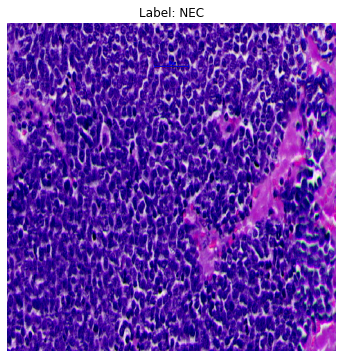

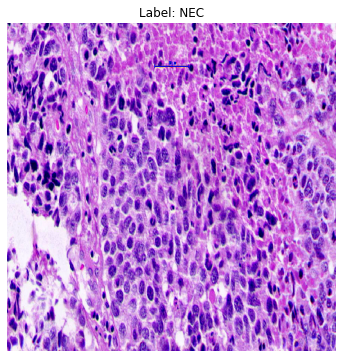

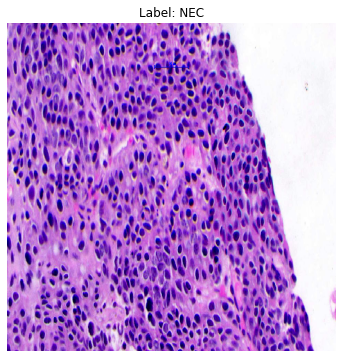

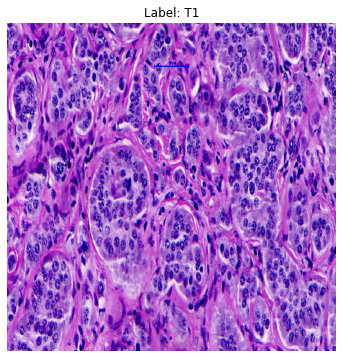

<function matplotlib.pyplot.show(close=None, block=None)>

In [2]:
##########           Image generators           ##########
    
seed=123 

train_datagen = ImageDataGenerator(#rescale=1./255,
                                    #rotation_range = 5,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #width_shift_range=0.0,
                                    #height_shift_range=0.0,
                                    fill_mode='wrap',
                                    #brightness_range=None,
                                    #horizontal_flip=True,
                                    #vertical_flip=True,
                                    validation_split=0.2,# set validation split
                                    preprocessing_function=preprocess
                                  )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess) #val data can't be augmented

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    subset='training',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    seed=seed,    # same shluffle seed in both generators 
                                                    shuffle=True, # to get correct train/val split
                                                    target_size=(SIZE,SIZE)
                                                    )

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH, # same directory as training data
                                                         subset='validation',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='binary',
                                                         seed=seed,
                                                         shuffle=True,
                                                         target_size=(SIZE,SIZE)
                                                    )

images, labels = train_generator.__next__()
print('Images is shape', images.shape)
    
for i in range(4):
    f = plt.figure(figsize = (20, 20))
    f.add_subplot(1,3,1)
    plt.axis('off')
    plt. title('Label: '+str(CLASSES[int(labels[i])]))
    plt.imshow(images[i])
plt.show(block=True)
plt.show

In [3]:
##########          CNN Construction           ##########

IMG_SHAPE = (SIZE, SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

2022-08-08 12:24:26.777298: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-08 12:24:31.319822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-08 12:24:31.319929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-08 12:24:31.361507: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-08 12:24:31.361647: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-08 12:24:31.373758: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [4]:
##########           Training           ##########

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                   )

save_path = './trained_models/classification_model_08-08-2022.hdf5'
print('Saving model to:', save_path)
model.save(save_path)

2022-08-08 12:24:36.347585: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-08 12:24:36.349415: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2700000000 Hz


Epoch 1/20


/mnt/beegfs/spack/opt/spack/linux-centos7-x86_64/gcc-4.9.4/miniconda3-4.3.30-rc2pkggawlbh6twcvefw6pwv7sgc6bc5/envs/tensorflow_2.5/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-08-08 12:24:39.254274: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-08-08 12:24:40.514886: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2022-08-08 12:24:42.211382: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-08 12:24:43.234966: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


16/16 [==============================] - 23s 1s/step - loss: 0.4365 - accuracy: 0.8449 - val_loss: 0.4769 - val_accuracy: 0.8197
Epoch 2/20
16/16 [==============================] - 15s 952ms/step - loss: 0.3959 - accuracy: 0.8959 - val_loss: 0.4551 - val_accuracy: 0.8279
Epoch 3/20
16/16 [==============================] - 15s 963ms/step - loss: 0.3653 - accuracy: 0.9286 - val_loss: 0.4351 - val_accuracy: 0.8279
Epoch 4/20
16/16 [==============================] - 16s 976ms/step - loss: 0.3356 - accuracy: 0.9306 - val_loss: 0.4149 - val_accuracy: 0.8279
Epoch 5/20
16/16 [==============================] - 15s 961ms/step - loss: 0.3103 - accuracy: 0.9429 - val_loss: 0.3951 - val_accuracy: 0.8443
Epoch 6/20
16/16 [==============================] - 15s 972ms/step - loss: 0.2860 - accuracy: 0.9510 - val_loss: 0.3789 - val_accuracy: 0.8525
Epoch 7/20
16/16 [==============================] - 16s 977ms/step - loss: 0.2658 - accuracy: 0.9571 - val_loss: 0.3616 - val_accuracy: 0.8852
Epoch 8/20
16

/mnt/beegfs/spack/opt/spack/linux-centos7-x86_64/gcc-4.9.4/miniconda3-4.3.30-rc2pkggawlbh6twcvefw6pwv7sgc6bc5/envs/tensorflow_2.5/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


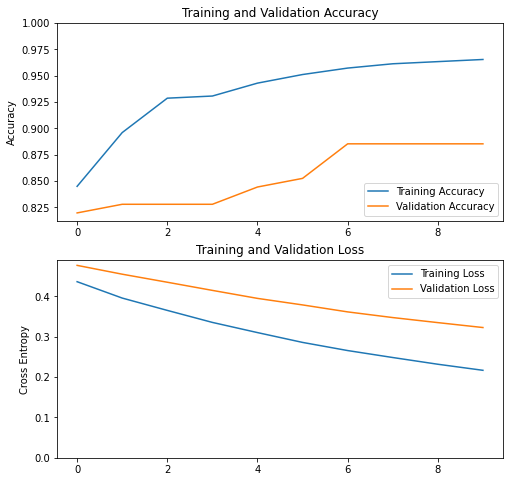

Maximum validation accuracy reached:  0.8852459192276001
Maximum validation accuracy reached at epoch:  7


In [5]:
##########           Model evaluation           ##########

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

max_iou = max(val_acc)
print ("Maximum validation accuracy reached: ", max_iou)
max_index = val_acc.index(max_iou)
print("Maximum validation accuracy reached at epoch: ",max_index+1)

In [8]:
##########           Model test           ##########
from keras.models import load_model

path = './trained_models/classification_model_08-08-2022.hdf5'
#model = load_model(path, compile=True)
    

test_datagen = ImageDataGenerator(preprocessing_function=preprocess)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                            batch_size=BATCH_SIZE,
                                            class_mode='binary',
                                            shuffle=True,
                                            target_size=(SIZE,SIZE)
                                        )


# Evaluate on Validation data
scores = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("Evaluate ",model.metrics_names[1], scores[1]*100))


Found 152 images belonging to 2 classes.
4/4 [==============================] - 3s 744ms/step - loss: 0.3616 - accuracy: 0.8852
evaluate accuracy: 88.52%
